In [0]:
displayHTML("""<font size=8' color='#884846' face="sans-serif">Projet Python Avance: Classification du prix des bijoux du site Histoire d'or </font>""")

Projet Python Avance: Classification du prix des bijoux du site Histoire d'or

In [0]:
displayHTML("""<font size="4" color="#595949" face="sans-serif">Fancello Marie Clara, Germini Eva, Gutfreund Eloise</font>""")

Fancello Marie Clara, Germini Eva, Gutfreund Eloise

L'objective de ce projet est de predire le prix (en categorielle) des bijoux feminins du site Histoire d'Or. Precedemment, nous avons extrait les donnees du site par une technique de web scaping sur python.

In [0]:
displayHTML("""<font size=6' color='#884846' face="sans-serif">I) Premiers traitements </font>""")

I) Premiers traitements

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Importation des libraires </font>""")

Importation des libraires

In [0]:
#Pour le traitement de la base de donnees
from pyspark.sql.functions import regexp_extract, col, isnan, when, mean, count, col, regexp_replace, isnull
import pyspark.sql.functions as F 

#Pour les statistiques descriptives 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.stat import Correlation

#Pour le modele de machine learning 
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Lecture et formation de la base de donnees </font>""")

Lecture et formation de la base de donnees

In [0]:
#Importation de la data
df1 = spark.read.format("csv").option("header", "true").option("sep", ";").load("dbfs:/FileStore/shared_uploads/eva.germini@etu.univ-paris1.fr/data-3.csv")

#Apercu de la base de donnees
df1.show()

+--------------------+------+--------------------+
|             article|  prix|         description|
+--------------------+------+--------------------+
|['\nBague Clothil...|159.00|"{<span class=""c...|
|"[""\nBoucles D'o...|  null|                null|
|['\nBague Manon O...|169.00|"{<span class=""c...|
|['\nCréoles Sandr...| 89.00|"{<span class=""c...|
|['\nCollier Mukad...| 79.00|"{<span class=""c...|
|['\nChaîne Igoa M...| 99.00|"{<span class=""c...|
|['\nCollier Doubl...|109.00|"{<span class=""c...|
|['\nBracelet Barr...| 99.00|"{<span class=""c...|
|['\nCollier Ponam...| 99.00|"{<span class=""c...|
|['\nCréoles Andge...| 99.00|"{<span class=""c...|
|['\nCollier Petit...| 89.00|"{<span class=""c...|
|['\nCollier Laury...| 75.00|"{<span class=""c...|
|['\nCréoles Valen...|119.00|"{<span class=""c...|
|['\nBague Smerald...| 99.00|"{<span class=""c...|
|['\nCollier Rosal...|159.00|"{<span class=""c...|
|"[""\nBoucles D'o...|  null|                null|
|['\nCollier Cloth...|169.00|"{

Nous creeons une nouvelle variable nommee "categorie" correspondant au type de produits presents dans notre base de donnees:

In [0]:
#Nous distinguons trois 4 catégories importantes pour l'analyse de bijoux: les bagues, les boucles d'oreilles, collier et bracelet.
df1 = df1.withColumn("categorie", F.when(df1.article.contains('Bague') | df1.article.contains('Alliance') | df1.article.contains('Chevalière'), 'Bague').when(df1.article.contains('Boucles') | df1.article.contains('Créoles'), 'Boucles').when(df1.article.contains('Collier'), 'Collier').when(df1.article.contains('Bracelet'), 'Bracelet').otherwise('Autres'))

Nettoyage de la variable "description":

In [0]:
#Utilisation de regex pour nettoyer la variable "description" afin de la rendre exploitable
df1 = df1.withColumn("desc_new", regexp_replace("description", "Couleur matière", "CoulMat"))
df1 = df1.withColumn("desc_new", regexp_replace("desc_new", "[^0-9A-Za-z^,^.]", ""))
df1 = df1.withColumn("desc_new", regexp_replace("desc_new", "spanclasscproductattributeslabel", ""))
df1 = df1.withColumn("desc_new", regexp_replace("desc_new", "spanclasscproductattributesvalue", ""))
df1 = df1.withColumn("desc_new", regexp_replace("desc_new", "span", ""))
df1 = df1.withColumn("desc_new", regexp_replace("desc_new", "\.", "unite"))

#Suppression des variables "article" et "description"
df1 = df1.drop("article", "description")

Nous supprimons les articles pour lesquels nous n'avons pas de description (car inexploitable):

In [0]:
df1 = df1.na.drop(subset=["desc_new"])
df1.show()

+------+---------+--------------------+
|  prix|categorie|            desc_new|
+------+---------+--------------------+
|159.00|    Bague|GenreFemme,Tourde...|
|169.00|    Bague|GenreFemme,Tourde...|
| 89.00|  Boucles|GenreFemme,Poidst...|
| 79.00|  Collier|GenreFemme,Poidst...|
| 99.00|   Autres|GenreFamille,Poid...|
|109.00|  Collier|GenreFemme,Poidst...|
| 99.00| Bracelet|GenreFemme,Poidst...|
| 99.00|  Collier|GenreFemme,Poidst...|
| 99.00|  Boucles|GenreFemme,Poidst...|
| 89.00|  Collier|GenreFemme,Poidst...|
| 75.00|  Collier|GenreFemme,Poidst...|
|119.00|  Boucles|GenreFemme,Poidst...|
| 99.00|    Bague|GenreFemme,Tourde...|
|159.00|  Collier|GenreFemme,Poidst...|
|169.00|  Collier|GenreFemme,Poidst...|
| 75.00|    Bague|GenreFemme,Tourde...|
|105.00|   Autres|GenreFemme,Rfrenc...|
| 99.00|    Bague|GenreFemme,Tourde...|
| 99.00|  Collier|GenreFemme,Poidst...|
|109.00|  Boucles|GenreFemme,Poidst...|
+------+---------+--------------------+
only showing top 20 rows



Creation de nouvelles variables a partir de la variable de description. Les variables sont les suivantes: 
- le poids de l'article 
- la matiere de l'article 
- couleur de la matière 
- type de pierres sur le bijou 
- couleur des pierres 
- la forme des pierres 
- le nombre de pierres 
- le type de motifs sur le bijou 
- la longueur de l'article  
- la largeur de l'article

In [0]:
#Creation de nouvelles variable a partir de la description de l'article
df1 = df1.withColumn('poids', F.regexp_extract(df1['desc_new'],'(Poidstotalgr)(\w+)(,)', 2))
df1 = df1.withColumn("poids", regexp_replace("poids", "unite", "."))
df1 = df1.withColumn('matiere', F.regexp_extract(df1['desc_new'],'(Matireprincipale)(\w+)(,)', 2))
df1 = df1.withColumn('couleur_mat', F.regexp_extract(df1['desc_new'],'(CoulMat)(\w+)(,)', 2))
df1 = df1.withColumn('type_pierre', F.regexp_extract(df1['desc_new'],'(Typedepierre)(\w+)(,)', 2))
df1 = df1.withColumn('couleur_pierre', F.regexp_extract(df1['desc_new'],'(Couleur)(\w+)(,)', 2))
df1 = df1.withColumn('forme', F.regexp_extract(df1['desc_new'],'(Forme)(\w+)(,)', 2))
df1 = df1.withColumn('type_motif', F.regexp_extract(df1['desc_new'],'(Typedemotif)(\w+)(,)', 2))
df1 = df1.withColumn('nb_pierre', F.regexp_extract(df1['desc_new'],'(Nombredepierres)(\w+)(,)', 2))
df1 = df1.withColumn('longueur', F.regexp_extract(df1['desc_new'],'(Longueurcm)(\w+)(,)', 2))
df1 = df1.withColumn('largueur', F.regexp_extract(df1['desc_new'],'(Largueurmm)(\w+)(,)', 2))

#Suppression de la variable "desc_new"
df1 = df1.drop("desc_new")

#Apercu de la base de donnees apres creation de variable 
df1.show()

+------+---------+-----+-------+-----------+--------------+--------------+--------------+----------+---------+--------+--------+
|  prix|categorie|poids|matiere|couleur_mat|   type_pierre|couleur_pierre|         forme|type_motif|nb_pierre|longueur|largueur|
+------+---------+-----+-------+-----------+--------------+--------------+--------------+----------+---------+--------+--------+
|159.00|    Bague|  0.9|     Or|      Blanc|         Oxyde|         Blanc|         Ronde|       Cur|        2|        |        |
|169.00|    Bague| 0.94|     Or|      Blanc|         Oxyde|         Blanc|         Ronde|          |       12|        |        |
| 89.00|  Boucles| 0.70|     Or|      Jaune|        Strass|         Blanc|  globaleRonde|          |         |        |        |
| 79.00|  Collier| 2.49| Argent|      Blanc|         Ambre|    Mielcognac|              |       Cur|         |      45|        |
| 99.00|   Autres| 0.88|     Or|      Jaune|              |              |              |        

Nous analysons les dimensions de la base de donnees: 
- Avant le traitement des doublons 
- Après le traitement des doublons

In [0]:
#Taille de la base de donnees avant suppression des doublons 
print("Il y a " + str(df1.count()) + " observations avant suppression des doublons.")
print("Il y a " + str(len(df1.columns)) + " variables avant suppression des doublons.")

Il y a 2426 observations avant suppression des doublons.
Il y a 12 variables avant suppression des doublons.


In [0]:
#Comptage des doublons 
df_no_dup = df1.distinct()
print("Il y a " + str((df1.count())-(df_no_dup.count())) + " doublons.")

Il y a 59 doublons.


In [0]:
#Suppression des doublons dans la base principale 
df1 = df1.distinct()

In [0]:
#Taille de la base de donnees apres suppression des doublons
print("Il y a " + str(df1.count()) + " observations apres suppression des doublons.")
print("Il y a " + str(len(df1.columns)) + " variables apres suppression des doublons.")

Il y a 2367 observations apres suppression des doublons.
Il y a 12 variables apres suppression des doublons.


In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Traitement des valeurs manquantes </font>""")

Traitement des valeurs manquantes

Deux types de valeurs manquantes sont dans notre base: 
- vide 
- null 

==> A la place du null, nous inserons du vide pour ensuite les caracteriser en reelles valeurs manquantes.

In [0]:
df1 = df1.na.fill(value='')

In [0]:
df1 = df1.withColumn("prix", F.when(df1.prix=='', F.lit(float('nan'))).otherwise(df1.prix))
df1 = df1.withColumn("categorie", F.when(df1.categorie=='', F.lit(float('nan'))).otherwise(df1.categorie))
df1 = df1.withColumn("poids", F.when(df1.poids=='', F.lit(float('nan'))).otherwise(df1.poids))
df1 = df1.withColumn("matiere", F.when(df1.forme=='', F.lit(float('nan'))).otherwise(df1.matiere))
df1 = df1.withColumn("couleur_mat", F.when(df1.couleur_mat=='', F.lit(float('nan'))).otherwise(df1.couleur_mat))
df1 = df1.withColumn("type_pierre", F.when(df1.type_pierre=='', F.lit(float('nan'))).otherwise(df1.type_pierre))
df1 = df1.withColumn("couleur_pierre", F.when(df1.couleur_pierre=='', F.lit(float('nan'))).otherwise(df1.couleur_pierre))
df1 = df1.withColumn("forme", F.when(df1.forme=='', F.lit(float('nan'))).otherwise(df1.forme))
df1 = df1.withColumn("type_motif", F.when(df1.type_motif=='', F.lit(float('nan'))).otherwise(df1.type_motif))
df1 = df1.withColumn("nb_pierre", F.when(df1.nb_pierre=='', F.lit(float('nan'))).otherwise(df1.nb_pierre))
df1 = df1.withColumn("longueur", F.when(df1.longueur=='', F.lit(float('nan'))).otherwise(df1.longueur))
df1 = df1.withColumn("largueur", F.when(df1.largueur=='', F.lit(float('nan'))).otherwise(df1.largueur))
df1.show()

+------+---------+-----+-------+-----------+--------------+--------------+-------------+----------+---------+--------+--------+
|  prix|categorie|poids|matiere|couleur_mat|   type_pierre|couleur_pierre|        forme|type_motif|nb_pierre|longueur|largueur|
+------+---------+-----+-------+-----------+--------------+--------------+-------------+----------+---------+--------+--------+
|199.00| Bracelet| 0.94|     Or|      Jaune|       Diamant|         Blanc|        Ronde|     Vague|       20|      18|     NaN|
| 89.00|  Boucles|  6.8| Argent|      Blanc|           NaN|           NaN| globaleRonde|       NaN|      NaN|     NaN|     NaN|
|159.00|  Boucles| 0.43|     Or|      Jaune|Perledeculture|         Nacre| globaleRonde|       NaN|        2|     NaN|     NaN|
|149.00|  Collier| 1.03|    NaN|      Jaune|         Oxyde|         Blanc|          NaN|         V|      NaN|      42|     NaN|
| 79.00|  Collier|  3.2| Argent|      Blanc|         Oxyde|         Blanc|        Ronde|    Cercle|     

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif"> Analyse du type des variables </font>""")

Analyse du type des variables

Nous observons que les variables continues: "prix", "longueur", "largueur", "poids" et "nb_pierre" sont de type caractere. Cependant, ce sont des variables continues:

In [0]:
#Analyse des types
df1.dtypes

Out[23]: [('prix', 'string'),
 ('categorie', 'string'),
 ('poids', 'string'),
 ('matiere', 'string'),
 ('couleur_mat', 'string'),
 ('type_pierre', 'string'),
 ('couleur_pierre', 'string'),
 ('forme', 'string'),
 ('type_motif', 'string'),
 ('nb_pierre', 'string'),
 ('longueur', 'string'),
 ('largueur', 'string')]

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Separation de la base de donnees </font>""")

Separation de la base de donnees

Nous avons choisi d'effectuer par la suite un algorithme de machine learning (supervised) de classification afin de predire si le prix sera bas, moyen ou eleve. En modelisation, il est important d'avoir une base test afin de tester la performance predictive de notre modèle. Dans la pratique, cette base test ne doit etre connue et ne peut donc servir a l'analyse statistique. Nous separons donc la data avant l'analyse statistique. Chaque changment effectue sur le train sera egalement effectue sur le test.

In [0]:
#Nous gardons 80% de la base de donnees pour l'entrainement du modele et 20% pour le test du modele 
train, test = df1.randomSplit([0.8, 0.2], seed=12345)

In [0]:
print("Il y a " + str(train.count()) + " observations dans le train.")
print("Il y a " + str(test.count()) + " observations dans le test.")

Il y a 1903 observations dans le train.
Il y a 464 observations dans le test.


In [0]:
displayHTML("""<font size=6' color='#884846' face="sans-serif">II) Statistiques descriptives univariees et transformations de variables  </font>""")

II) Statistiques descriptives univariees et transformations de variables

Lorsque l'on utilise un modele de classfication, il est recommander (voir parfois necessaire) de ne pas avoir de valeurs manquantes dans la base de donnees. Egalement, si les variables sont continues, il est judicieux de le discretiser. 

Dans cette partie, nous utiliserons donc les statistiques descriptives pour: 
- la gestion des valeurs manquantes et aberrantes 
- la formation de variables discretisees

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Analyse des valeurs manquantes  </font>""")

Analyse des valeurs manquantes

Au sein du train, les variables "categorie" et "prix" n'ont pas de valeurs manquantes. Les variables donnant des informations sur la pierre ne sont pas renseignees dans environs 35% des cas, cela s'explique par le fait que certains bijoux n'ont pas de pierres.

In [0]:
train.select([(count(when(isnan(c), c))/train.count()*100).alias(c) for c in train.columns]).show()

+----+---------+-----------------+-----------------+------------------+------------------+---------------+-----------------+----------------+-----------------+-----------------+--------+
|prix|categorie|            poids|          matiere|       couleur_mat|       type_pierre| couleur_pierre|            forme|      type_motif|        nb_pierre|         longueur|largueur|
+----+---------+-----------------+-----------------+------------------+------------------+---------------+-----------------+----------------+-----------------+-----------------+--------+
| 0.0|      0.0|2.312138728323699|33.57856016815554|0.1576458223857068|34.839726747241194|34.944823962165|33.57856016815554|64.9500788229112|40.19968470835523|60.27325275880189|   100.0|
+----+---------+-----------------+-----------------+------------------+------------------+---------------+-----------------+----------------+-----------------+-----------------+--------+



Nous observons que seule la variables largueur présente 100% de valeurs manquantes, donc, nous la supprimons.

In [0]:
#Suppression des variables ayant plus de 80% de valeurs manquantes 
#Au sein du train 
train = train.drop("largueur")
#Au sein du test 
test = test.drop("largueur")

#Apercu de la base train 
train.show()

+------+---------+-----+-------+-----------+-----------+--------------+--------------+----------+---------+--------+
|  prix|categorie|poids|matiere|couleur_mat|type_pierre|couleur_pierre|         forme|type_motif|nb_pierre|longueur|
+------+---------+-----+-------+-----------+-----------+--------------+--------------+----------+---------+--------+
|105.00|   Autres|  NaN|  Acier|      Blanc|     Strass|duboitierBlanc|duboitierRonde|       NaN|      NaN|     NaN|
|109.00|   Autres|  0.8|    NaN|   Bicolore|        NaN|           NaN|           NaN|       NaN|      NaN|     NaN|
|109.00|   Autres|  0.8|    NaN|      Jaune|        NaN|           NaN|           NaN|       NaN|      NaN|     NaN|
|109.00|   Autres|    1|    NaN|      Blanc|        NaN|           NaN|           NaN|       NaN|      NaN|      45|
|109.00|   Autres|    1|    NaN|      Jaune|        NaN|           NaN|           NaN|       NaN|      NaN|      42|
|109.00|   Autres|    1|    NaN|      Jaune|        NaN|        

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Description de notre variable d'intéret  </font>""")

Description de notre variable d'intéret

Changement du type de la variable:

In [0]:
train = train.withColumn("prix",train.prix.cast('int'))
test = test.withColumn("prix",test.prix.cast('int'))

- En moyenne le prix est de 259 euros. 50% des articles ont un prix superieur à 179 euros. La mediane est donc bien inferieure à la moyenne. Ce qui indique une presence d'outliers.  
- La transformation de la variable d'interet en catégorielle permet de traiter ces outliers.

In [0]:
#Statistiques descriptives du prix 
stat_desc = train.select("prix").summary().show()

+-------+-----------------+
|summary|             prix|
+-------+-----------------+
|  count|             1903|
|   mean|259.8838675775092|
| stddev|275.5784446314637|
|    min|               15|
|    25%|              119|
|    50%|              179|
|    75%|              279|
|    max|             3990|
+-------+-----------------+



Egalement, nous observons que la variable du prix ne suit pas une loi normale. 
Le boxplot de la variable du prix indique bien des valeurs aberrantes:

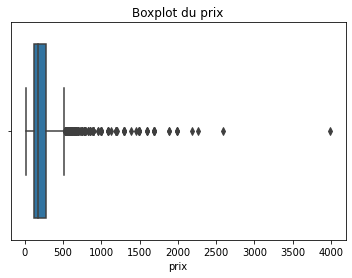

In [0]:
#Boxplot du prix 
boxplot_1 = train.select("prix")
boxplot_1 = boxplot_1.toPandas()
ax = sns.boxplot(x="prix",data=boxplot_1)
ax.set_title("Boxplot du prix")
ax.set_xlabel('prix')
plt.show()

Transformation de la variables continue du prix en une variable categorielle. Nous souhaitons obtenir trois categories de prix. 
- les prix bas (1)
- les prix moyens (2)
- les prix eleves (3). 

Pour obtenir des classes equilibree, nous divisons les prix en trois classes.

In [0]:
train.agg(F.percentile_approx("prix", 0.3333).alias("cut_1")).show()
train.agg(F.percentile_approx("prix", 0.6666).alias("cut_2")).show()

+-----+
|cut_1|
+-----+
|  139|
+-----+

+-----+
|cut_2|
+-----+
|  229|
+-----+



In [0]:
#Changements sur le train 
train = train.withColumn("prix_cat", F.when(train.prix<=139, '1').when(train.prix>229, '3').otherwise('2'))
train = train.drop("prix")
#Changements sur le test 
test = test.withColumn("prix_cat", F.when(test.prix<=139, '1').when(test.prix>229, '3').otherwise('2'))
test = test.drop("prix")

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Descriptions et changements des variables continues </font>""")

Descriptions et changements des variables continues

In [0]:
displayHTML("""<font size=3' color='black' face="sans-serif"> Poids de l'article </font>""")

Poids de l'article

Le poids de l'article presente 2,31% de valeurs manquantes. Ce chiffre étant faible, nous remplacons ces valeurs manquantes par la mediane de la variable car cette derniere presente des outliers comme le confirme le boxplot ci-dessus:

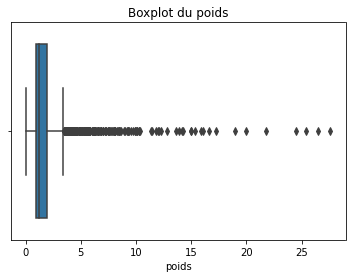

In [0]:
#Boxplot du poids 
df_poids = train.select("poids")
df_poids = train.withColumn("poids",df_poids.poids.cast('float'))
boxplot_2 = df_poids.toPandas()
ax = sns.boxplot(x="poids",data=boxplot_2)
ax.set_title("Boxplot du poids")
ax.set_xlabel('poids')
plt.show()

La median du poids est de 1.28 gramme. Nous remplacons donc les valeurs manquantes par cette valeur:

In [0]:
#stat_desc_poids = df_poids.select("poids").summary().show()

#Changement des valeurs manquantes 
train = train.na.fill(value="1.28",subset=["poids"])
test = test.na.fill(value="1.28",subset=["poids"])

#Changement du type de la variable 
train = train.withColumn("poids",train.poids.cast('float'))
test = test.withColumn("poids",test.poids.cast('float'))

#Point de coupure pour tranformer la variable en categorielle 
train.agg(F.percentile_approx("poids", 0.3333).alias("cut_1")).show()
train.agg(F.percentile_approx("poids", 0.6666).alias("cut_2")).show()

+-----+
|cut_1|
+-----+
| 1.05|
+-----+

+-----+
|cut_2|
+-----+
| 1.68|
+-----+



Nous souhaitons obtenir trois categories de poids. Les poids faibles (1), les poids moyens (2) et les poids eleves (3):

In [0]:
#Changements sur le train 
train = train.withColumn("poids_cat", F.when(train.poids<=1.05, '1').when(train.poids>1.6, '3').otherwise('2'))
train = train.drop("poids")
#Changements sur le test 
test = test.withColumn("poids_cat", F.when(test.poids<=1.05, '1').when(test.poids>1.6, '3').otherwise('2'))
test = test.drop("poids")

In [0]:
displayHTML("""<font size=3' color='black' face="sans-serif"> Longueur de l'article </font>""")

Longueur de l'article

Il est difficile d'interpreter les statistiques de la longueur car elle presente 60% de valeurs manquantes. Cependant, nous savons que lorsque cette variable n'est pas renseignees, cela signifie que: le produit ne possedent pas de longueur. A titre d'exemple, les bagues ou les alliances n'ont pas de longueur. Les valeurs manquantes se trouveront donc dans une nouvelle categorie. 

La variable longueur presente des outliers, en effet sa moyenne de 35 est inferieure a sa mediane de 42. Cela signifie que lorsque la variable longueur est renseignee, 50% des longueurs sont inferieures à 42. La longueur maximale des bijoux est de 120 cm et la longueur minimale est de 16 cm.

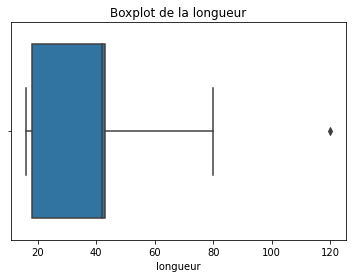

+-------+------------------+
|summary|          longueur|
+-------+------------------+
|  count|               756|
|   mean|35.383597883597886|
| stddev|13.263641315467366|
|    min|                16|
|    25%|                18|
|    50%|                42|
|    75%|                43|
|    max|               120|
+-------+------------------+



In [0]:
df_longueur = train.select("longueur")
df_longueur = train.withColumn("longueur",df_longueur.longueur.cast('int'))

#Boxplot de la longueur 
boxplot_3 = df_longueur.select("longueur")
boxplot_3 = boxplot_3.toPandas()
ax = sns.boxplot(x="longueur",data=boxplot_3)
ax.set_title("Boxplot de la longueur")
ax.set_xlabel('longueur')
plt.show()

#Statistiques descriptives de la longueur
stat_desc_longueur = df_longueur.select("longueur").summary().show()

Nous souhaitons obtenir trois categories de longueur. Les longueurs courtes (1), les longueurs longues (2) et pas de longueur (3).

In [0]:
#Changements sur le train 
train = train.withColumn("longueur_cat", F.when(train.longueur<=42, '1').when(train.longueur>42, '2').otherwise('3'))
train = train.drop("longueur")
#Changements sur le test 
test = test.withColumn("longueur_cat", F.when(test.longueur<=42, '1').when(test.longueur>42, '2').otherwise('3'))
test = test.drop("longueur")

In [0]:
displayHTML("""<font size=3' color='black' face="sans-serif"> Nombre de pierres </font>""")

Nombre de pierres

Il est difficile d'interpreter les statistiques du nombre de pierres car elle presente 40% de valeurs manquantes. Cependant, nous savons que lorsque cette variable n'est pas renseignees, cela signifie que le nombre de pierre est de 0.

Apres changement des valeurs manquantes, la variable "nb_pierre" presente des outliers, en effet sa moyenne de 9 est superieur a sa mediane de 1. 50% des bijoux ont un nombre de pierres inferieur a 1. Le nombre maximal de pierres est de 240 et Le nombre minimal de pierres est de 0.

+-------+------------------+
|summary|         nb_pierre|
+-------+------------------+
|  count|              1903|
|   mean| 9.703100367840252|
| stddev|19.832888220241323|
|    min|                 0|
|    25%|                 0|
|    50%|                 1|
|    75%|                12|
|    max|               240|
+-------+------------------+



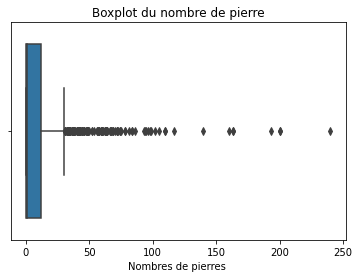

+-----+
|cut_1|
+-----+
|    0|
+-----+

+-----+
|cut_2|
+-----+
|    6|
+-----+



In [0]:
#Remplacement des valeurs manquantes par 0 
train = train.withColumn("nb_pierre", F.when(isnan(train.nb_pierre), '0').otherwise(train.nb_pierre))
test = test.withColumn("nb_pierre", F.when(isnan(test.nb_pierre), '0').otherwise(test.nb_pierre))

#Changement du type de la variable 
train = train.withColumn("nb_pierre",train.nb_pierre.cast('int'))
test = test.withColumn("nb_pierre",test.nb_pierre.cast('int'))

#Statistiques descriptives 
stat_desc_pierre = train.select("nb_pierre").summary().show()

#Boxplot 
boxplot_4 = train.select("nb_pierre")
boxplot_4 = boxplot_4.toPandas()
ax = sns.boxplot(x="nb_pierre",data=boxplot_4)
ax.set_title("Boxplot du nombre de pierre")
ax.set_xlabel('Nombres de pierres ')
plt.show()

#Point de coupure pour tranformer la variable en categorielle 
train.agg(F.percentile_approx("nb_pierre", 0.3333).alias("cut_1")).show()
train.agg(F.percentile_approx("nb_pierre", 0.6666).alias("cut_2")).show()

Nous souhaitons obtenir trois categories du nombre de pierre.  Pas de pierre (1), Nombre moyen de pierres (2) et Nombre eleve de pierres (3):

In [0]:
#Changements sur le train 
train = train.withColumn("nb_pierre_cat", F.when(train.nb_pierre<=0, '1').when(train.nb_pierre>6, '3').otherwise('2'))
train = train.drop("nb_pierre")
#Changements sur le test 
test = test.withColumn("nb_pierre_cat", F.when(test.nb_pierre<=0, '1').when(test.nb_pierre>6, '3').otherwise('2'))
test = test.drop("nb_pierre")

#Apercu de la base 
train.show()

+---------+-------+-----------+-----------+--------------+--------------+----------+--------+--------+---------+-------------+
|categorie|matiere|couleur_mat|type_pierre|couleur_pierre|         forme|type_motif|longueur|prix_cat|poids_cat|nb_pierre_cat|
+---------+-------+-----------+-----------+--------------+--------------+----------+--------+--------+---------+-------------+
|   Autres|  Acier|      Blanc|     Strass|duboitierBlanc|duboitierRonde|       NaN|     NaN|       1|        3|            1|
|   Autres|    NaN|   Bicolore|        NaN|           NaN|           NaN|       NaN|     NaN|       1|        1|            1|
|   Autres|    NaN|      Jaune|        NaN|           NaN|           NaN|       NaN|     NaN|       1|        1|            1|
|   Autres|    NaN|      Blanc|        NaN|           NaN|           NaN|       NaN|      45|       1|        1|            1|
|   Autres|    NaN|      Jaune|        NaN|           NaN|           NaN|       NaN|      42|       1|        1

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Descriptions et changements des variables catégorielles </font>""")

Descriptions et changements des variables catégorielles

In [0]:
displayHTML("""<font size=3' color='black' face="sans-serif"> Analyse des classes </font>""")

Analyse des classes

Rappel sur le nombre de NaN par variables: 
- categorie: 0%
- matiere: 33%
- couleur_mat: 0.15%
- type_pierre: 34%
- couleur_pierre: 34%
- forme (de la pierre): 33%
- type_motif (de la pierre): 64%

In [0]:
categorie = train.groupBy("categorie").count().show()
matiere = train.groupBy("matiere").count().show()
couleur_mat = train.groupBy("couleur_mat").count().show()
type_pierre = train.groupBy("type_pierre").count().show()
couleur_pierre = train.groupBy("couleur_pierre").count().show()
forme = train.groupBy("forme").count().show()
type_motif = train.groupBy("type_motif").count().show()

+---------+-----+
|categorie|count|
+---------+-----+
|  Boucles|  146|
|  Collier|  421|
|   Autres|  206|
| Bracelet|  299|
|    Bague|  831|
+---------+-----+

+-------+-----+
|matiere|count|
+-------+-----+
|Platine|    5|
| Argent|  100|
|     Or| 1114|
| Autres|    2|
|    NaN|  639|
|Plaquor|   41|
|  Acier|    2|
+-------+-----+

+-----------+-----+
|couleur_mat|count|
+-----------+-----+
|       Rose|  127|
|  Tricolore|   28|
|      Jaune|  846|
|     Autres|    2|
|      Blanc|  793|
|        NaN|    3|
|   Bicolore|  103|
|       Noir|    1|
+-----------+-----+

+-----------------+-----+
|      type_pierre|count|
+-----------------+-----+
|            Rubis|   17|
|        Amethyste|   21|
|       Tourmaline|    1|
|             Onyx|    1|
|        Ceramique|    2|
|       Aventurine|    3|
|            Agate|    1|
|           Saphir|   28|
|       Calcedoine|    1|
|     PierredeLune|    1|
|           Quartz|    4|
|           Strass|   14|
|            Oxyde|  438|
|  

In [0]:
displayHTML("""<font size=3' color='black' face="sans-serif"> Transformations des variables </font>""")

Transformations des variables

La variable "matiere" representant la matiere du bijou peut etre separee en trois groupes: or (1) étant le plus represente, autre (2) representant les autres matieres et non connues (3) representant les valeurs manquantes (33%).

In [0]:
#Changements sur le train 
train = train.withColumn("matiere_new", F.when(train.matiere=='Or', '1').when(isnan(train.matiere), '3').otherwise('2'))
train = train.drop("matiere")
#Changements sur le test 
test = test.withColumn("matiere_new", F.when(test.matiere=='Or', '1').when(isnan(test.matiere), '3').otherwise('2'))
test = test.drop("matiere")

La variable "couleur_mat" representant la couleur du bijou peut etre separee en trois groupes: jaune (1) etant le plus represente, blanc (2) et autres (3) dans laquelle nous plaçons les NaN car ils sont au nombre de 3.

In [0]:
#Changements sur le train 
train = train.withColumn("couleur", F.when(train.couleur_mat=='Jaune', '1').when(train.couleur_mat=='Blanc', '2').otherwise('3'))
train = train.drop("couleur_mat")
#Changements sur le test 
test = test.withColumn("couleur", F.when(test.couleur_mat=='Jaune', '1').when(test.couleur_mat=='Blanc', '2').otherwise('3'))
test = test.drop("couleur_mat")

La variable "forme" representant la forme de la pierre peut etre separee en trois groupes: ronde (1) etant le plus represente, autre (2) representant les autres formes et non connues (3) representant les valeurs manquantes (33%).

In [0]:
#Changements sur le train 
train = train.withColumn("forme_new", F.when(train.forme.contains('Ronde') | train.forme.contains('globaleRonde'), '1').when(isnan(train.forme), '3').otherwise('2'))
train = train.drop("forme")
#Changements sur le test 
test = test.withColumn("forme_new", F.when(test.forme.contains('Ronde') | test.forme.contains('globaleRonde'), '1').when(isnan(test.forme), '3').otherwise('2'))
test = test.drop("forme")

La variable "couleur_pierre" peut etre separee en trois groupes: blanc (1) etant le plus represente, autre (2) representant les autres couleurs et non connues (3) representant les valeurs manquantes (34%).

In [0]:
#Changements sur le train 
train = train.withColumn("coul_pierre_new", F.when(train.couleur_pierre.contains('Blanc'), '1').when(isnan(train.couleur_pierre), '3').otherwise('2'))
train = train.drop("couleur_pierre")
#Changements sur le test 
test = test.withColumn("coul_pierre_new", F.when(test.couleur_pierre.contains('Blanc'), '1').when(isnan(test.couleur_pierre), '3').otherwise('2'))
test = test.drop("couleur_pierre")

Les variables "type_pierre" et "type_motif" ne seront pas utilisees au sein du modele car leur nombre de modalites est important et egalement car aucune modalite n'a un nombre superieur au nombre de valeurs manquantes.

In [0]:
train = train.drop("type_pierre", "type_motif")
test = test.drop("type_pierre", "type_motif")

In [0]:
#Nombre d'article par modalite apres changement des variables 
matiere = train.groupBy("matiere_new").count().show()
couleur_mat = train.groupBy("couleur").count().show()
couleur_pierre = train.groupBy("coul_pierre_new").count().show()
forme = train.groupBy("forme_new").count().show()

+-----------+-----+
|matiere_new|count|
+-----------+-----+
|          3|  639|
|          1| 1114|
|          2|  150|
+-----------+-----+

+-------+-----+
|couleur|count|
+-------+-----+
|      3|  264|
|      1|  846|
|      2|  793|
+-------+-----+

+---------------+-----+
|coul_pierre_new|count|
+---------------+-----+
|              3|  665|
|              1|  989|
|              2|  249|
+---------------+-----+

+---------+-----+
|forme_new|count|
+---------+-----+
|        3|  639|
|        1| 1058|
|        2|  206|
+---------+-----+



Vérification apres changements des variables:

In [0]:
train.select([(count(when(isnan(c), c))/train.count()*100).alias(c) for c in train.columns]).show()
train.show()

+---------+--------+---------+------------+-------------+-----------+-------+---------+---------------+
|categorie|prix_cat|poids_cat|longueur_cat|nb_pierre_cat|matiere_new|couleur|forme_new|coul_pierre_new|
+---------+--------+---------+------------+-------------+-----------+-------+---------+---------------+
|      0.0|     0.0|      0.0|         0.0|          0.0|        0.0|    0.0|      0.0|            0.0|
+---------+--------+---------+------------+-------------+-----------+-------+---------+---------------+

+---------+--------+---------+------------+-------------+-----------+-------+---------+---------------+
|categorie|prix_cat|poids_cat|longueur_cat|nb_pierre_cat|matiere_new|couleur|forme_new|coul_pierre_new|
+---------+--------+---------+------------+-------------+-----------+-------+---------+---------------+
|   Autres|       1|        3|           3|            1|          2|      2|        1|              1|
|   Autres|       1|        1|           3|            1|      

In [0]:
displayHTML("""<font size=6' color='#884846' face="sans-serif">III) Statistiques descriptives bivariees </font>""")

III) Statistiques descriptives bivariees

Dans cette section, nous croisons notre variable d'interet (le prix en categorielle) avec des variables que nous pensons discriminantes: 
- matiere_cat car l'or est plus chere que d'autres metaux 
- poids_cat car l'or pese plus lourd que d'autres metaux
- nb_pierre car les pierres precieuses ou diamants sont plus cheres

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Matiere </font>""")

Matiere

Pour la categorie or, notre supposition precedente est confirmee. Lorsque le bijou est en or son prix fait majoritairement parti des categories avec un prix eleve (orange) ou un prix moyen (vert). Nous observons egalement que pour les produits composes d'autres metaux, le prix est faible (bleu).

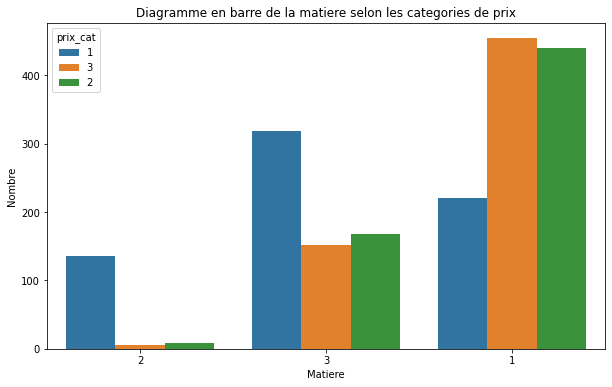

In [0]:
df_graph = train.toPandas()
plt.figure(figsize=(10,6))
ax = sns.countplot(x="matiere_new", hue="prix_cat",data=df_graph)
plt.title('Diagramme en barre de la matiere selon les categories de prix')
plt.xlabel('Matiere')
plt.ylabel('Nombre')
plt.show()

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Poids </font>""")

Poids

Pour la categorie avec un poids eleve, notre supposition precedente est confirmee. Lorsque le bijou est "lourd" son prix fait majoritairement parti de la categories avec un prix eleve (orange). A l'inverse, lorsque le bijou est "lege" son prix fait majoritairement parti de la categories avec un prix faible (bleu).

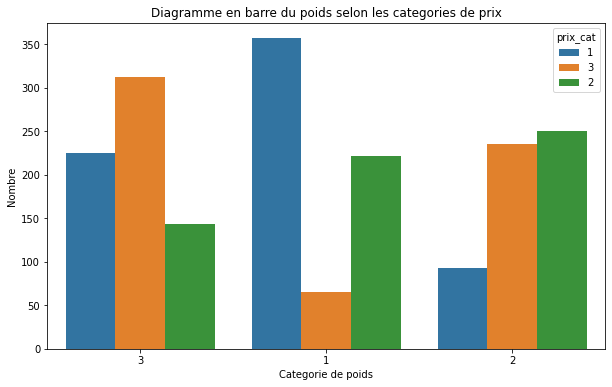

In [0]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="poids_cat", hue="prix_cat",data=df_graph)
plt.title('Diagramme en barre du poids selon les categories de prix')
plt.xlabel('Categorie de poids')
plt.ylabel('Nombre')
plt.show()

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Nombre de pierres  </font>""")

Nombre de pierres

Pour la categorie avec un nombre de pierres eleve, notre supposition precedente est confirmee: son prix fait majoritairement parti de la categories avec un prix eleve (orange). A l'inverse, lorsque le bijou a pas de pierres son prix fait majoritairement parti de la categories avec un prix faible (bleu).

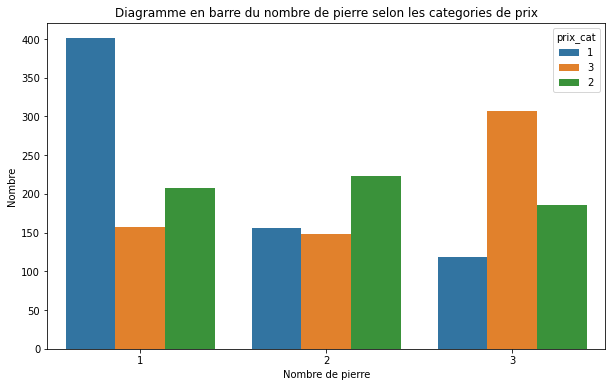

In [0]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="nb_pierre_cat", hue="prix_cat",data=df_graph)
plt.title('Diagramme en barre du nombre de pierre selon les categories de prix')
plt.xlabel('Nombre de pierre')
plt.ylabel('Nombre')
plt.show()

In [0]:
displayHTML("""<font size=6' color='#884846' face="sans-serif">IV) Modelisation </font>""")

IV) Modelisation

Dans cette partie, nous commencerons par transformer nos variables categorielles en variables binaires que nous placerons au sein d'une seule variable. 

Ensuite, nous allons utiliser un modele logit multiclass et une random forest avec une etape de GridSearchCV afin de regler les hyperparametres du modele. L'objectif est d'ameliorer les performances sur l'echantillon de test par la penalisation.

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Transformation de variables categorielles en variables binaires avant execution du modele </font>""")

Transformation de variables categorielles en variables binaires avant execution du modele

In [0]:
#Liste des variables a transformer
cols = train.drop("prix_cat").columns

#Changement du type des variables categorielles en StringIndexer 
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in cols
]

#One-hot-Encoding 
encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

#Placement des dummies au sein d'une variable nommee features 
assembler = VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders],
    outputCol="features"
)

#Pipeline permettant d'effectuer plusieurs changements 
pipeline = Pipeline(stages=indexers + encoders + [assembler])

#Changements sur le train 
train_1 = pipeline.fit(train).transform(train)
#Changements sur le test 
test_1 = pipeline.fit(train).transform(test)

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Modele logit </font>""")

Modele logit

In [0]:
#Changement de la variable d'interet en StringIndexer
labelIndexer = StringIndexer(inputCol="prix_cat", outputCol="label").fit(train_1)

#Modele Classifier
lr = LogisticRegression(labelCol="label", featuresCol="features")

#Pipeline
pipeline = Pipeline(stages=[labelIndexer, lr])

#Parametres de la GridSearchCV 
paramGrid = ParamGridBuilder().addGrid(lr.elasticNetParam, [0.01, 0.1, 0.3]).addGrid(lr.maxIter, [10, 50, 100]).build()

#GridSearchCV 
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)  

#Entrainement du modele 
model = crossval.fit(train_1)

/databricks/spark/python/pyspark/ml/util.py:839: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
  warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)


In [0]:
#Predictions
predictions = model.transform(train_1)

#Score final du modele sur l'échantillon de test 
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("L'accuracy du modele logit est de = %g " % (accuracy))

L'accuracy du modele logit est de = 0.630058 


L'accuracy du modele logit est de 63%.

In [0]:
displayHTML("""<font size=4' color='#858846' face="sans-serif">Modele random forest </font>""")

Modele random forest

In [0]:
#Changement de la variable d'interet en StringIndexer
#labelIndexer = StringIndexer(inputCol="prix_cat", outputCol="label").fit(train_1)

#Modele Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

#Pipeline
pipeline = Pipeline(stages=[labelIndexer, rf])

#Parametres de la GridSearchCV 
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 50, 100]).build()

#GridSearchCV 
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)  

In [0]:
#Predictions
predictions = cvModel.transform(train_1)

#Score final du modele sur l'échantillon de test 
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("L'accuracy du modele random forest est de = %g " % (accuracy))

L'accuracy du modele random forest est de = 0.698896 


L'accuracy du modele random est de 70%. Cela signifie que le modele ne predit pas la bonne classe de prix dans 30% des cas.

#CONCLUSION


- Dans un notebook python, nous avons webscape le site Histoire d'Or afin d'obtenir une base de donnees regroupant les articles pour femmes. 
- Au sein de ce notebook, nous avons forme la base de donnees et procede a des analyses statistiques. 
- La derniere etape de ce notebook consiste a former deux modeles de Machine Learning (classifiction supervise) afin de predire la categorie de prix des articles. 
- Finalement, le modele random forest a la meilleure capacite predictive. Il permet de predire la bonne classe de prix pour 70% des articles. 
- Nous allons proposer une comparaison de ces deux modeles avec la librairie sklearn de python afin de comparer les resultats.